# MosaicFM Gene Embedding Clusters Visualization

This notebook visualizes MosaicFM's learnt gene embeddings using dimensionality reduction techniques.

Author: Hamed Heydari @ Vevo  
Date: April, 2025

In [1]:
import torch
import numpy as np
import os
import pandas as pd
import logging
import umap 

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from omegaconf import OmegaConf as om
from mosaicfm.model import ComposerSCGPTModel
from mosaicfm.tokenizer import GeneVocab


# Set up logging
logging.basicConfig(
    format="%(asctime)s: [%(process)d][%(threadName)s]: %(levelname)s: %(name)s: %(message)s",
)
log = logging.getLogger(__name__)
log.setLevel("INFO")

/vevo/micromamba/envs/mosaicfm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_paths = {
    "mosaicfm-70m-tahoe": "/vevo/model/release/mosaicfm-70m-tahoe/",
}

# Select model
model_name = "mosaicfm-70m-tahoe"
model_config_path = os.path.join(model_paths[model_name], "model_config.yml")
vocab_path = os.path.join(model_paths[model_name], "vocab.json")
collator_config_path = os.path.join(model_paths[model_name], "collator_config.yml")
model_file = os.path.join(model_paths[model_name], "best-model.pt")

In [3]:
# Load configurations
model_config = om.load(model_config_path)
collator_config = om.load(collator_config_path)
vocab = GeneVocab.from_file(vocab_path)

# Initialize and load model
model = ComposerSCGPTModel(
    model_config=model_config,
    collator_config=collator_config
)
model.load_state_dict(torch.load(model_file)["state"]["model"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print(f"Model loaded on {device}")

/tmp/ipykernel_57745/2767462082.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file)["state"]["model"])


Model loaded on cuda


In [4]:
# Convert vocab to dataframe for easier inspection
vocab_dict = {
    'index': [],
    'token': []
}

for idx, token in vocab.index_to_token.items():
    vocab_dict['index'].append(idx)
    vocab_dict['token'].append(token)

vocab_df = pd.DataFrame(vocab_dict)
print(f"Vocabulary size: {len(vocab_df)}")
vocab_df.head()

Vocabulary size: 62720


index            token
0  62719          <junk6>
1  62717          <junk4>
2  62713          <junk0>
3  62708  ENSG00000291313
4  62707  ENSG00000291312

In [5]:
def extract_gene_embeddings(model, vocab, device, batch_size=1000):
    """
    Extract embeddings for all genes in the vocabulary.
    """
    gene2idx = vocab.get_stoi()
    all_gene_ids = np.array(list(gene2idx.values()))
    embedding_dim = model.model.gene_encoder.embedding.embedding_dim
    
    # Initialize array to store embeddings
    gene_embeddings = np.zeros((len(all_gene_ids), embedding_dim), dtype=np.float32)
    
    # Process genes in batches
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=True, dtype=torch.bfloat16):
        for i in tqdm(range(0, len(all_gene_ids), batch_size)):
            # Get batch of gene IDs
            batch_indices = all_gene_ids[i:i+batch_size]
            batch_tensor = torch.tensor(batch_indices, dtype=torch.long).to(device)
            
            # Get base embeddings
            token_embs = model.model.gene_encoder(batch_tensor)
            batch_embeddings = token_embs.to("cpu").to(torch.float32).numpy()
            gene_embeddings[i:i+batch_size] = batch_embeddings
    
    return gene_embeddings

# Extract base embeddings (from gene encoder only)
log.info("Extracting base gene embeddings...")
base_gene_embeddings = extract_gene_embeddings(model, vocab, device)
print(f"Base gene embeddings shape: {base_gene_embeddings.shape}")

2025-04-08 01:08:12,331: [57745][MainThread]: INFO: __main__: Extracting base gene embeddings...
/tmp/ipykernel_57745/3359618295.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True, dtype=torch.bfloat16):
100%|██████████| 63/63 [00:00<00:00, 936.13it/s]

Base gene embeddings shape: (62720, 512)


In [6]:
# Create output directory if it doesn't exist
output_dir = f"gene_embeddings_{model_name}"
os.makedirs(output_dir, exist_ok=True)

# Save both types of embeddings and gene info
gene_emb_save_path = os.path.join(output_dir, "gene_embeddings.npz")
np.savez(
    gene_emb_save_path,
    base_gene_embeddings=base_gene_embeddings,
    gene_names=list(vocab.index_to_token.values()),
    gene_ids=list(vocab.index_to_token.keys()),
)
log.info(f"Saved gene embeddings to {gene_emb_save_path}")

# Save vocabulary as CSV for reference
vocab_df.to_csv(os.path.join(output_dir, "vocabulary.txt"), index=False, sep="\t")
log.info(f"Saved vocabulary to {os.path.join(output_dir, 'vocabulary.txt')}")

2025-04-08 01:08:13,633: [57745][MainThread]: INFO: __main__: Saved gene embeddings to gene_embeddings_mosaicfm-70m-tahoe/gene_embeddings.npz
2025-04-08 01:08:13,671: [57745][MainThread]: INFO: __main__: Saved vocabulary to gene_embeddings_mosaicfm-70m-tahoe/vocabulary.txt


In [7]:
# Load the saved embeddings to verify they were saved correctly
saved_data = np.load(gene_emb_save_path)
print(f"Loaded data contains keys: {saved_data.files}")
print(f"Base embeddings shape: {saved_data['base_gene_embeddings'].shape}")
print(f"Number of genes: {len(saved_data['gene_names'])}")

# Display sample of gene names with their embeddings
sample_size = 5
sample_indices = np.random.choice(len(saved_data['gene_names']), sample_size, replace=False)

print("\nSample genes and their embeddings:")
for idx in sample_indices:
    gene_name = saved_data['gene_names'][idx]
    gene_id = saved_data['gene_ids'][idx]
    base_emb = saved_data['base_gene_embeddings'][idx]
    
    print(f"Gene: {gene_name}, ID: {gene_id}")
    print(f"Base embedding first 5 values: {base_emb[:5]}")
    print()

Loaded data contains keys: ['base_gene_embeddings', 'gene_names', 'gene_ids']
Base embeddings shape: (62720, 512)
Number of genes: 62720

Sample genes and their embeddings:
Gene: ENSG00000251591, ID: 39744
Base embedding first 5 values: [-0.86840934 -0.67767066 -0.96402353  0.3266483   0.37954366]

Gene: ENSG00000283256, ID: 56708
Base embedding first 5 values: [-0.77177787  0.51962775  0.6305239   0.13763176  0.10006753]

Gene: ENSG00000284743, ID: 57596
Base embedding first 5 values: [ 0.32633144  1.15993     0.44980133  0.6081892  -0.7063804 ]

Gene: ENSG00000140090, ID: 7914
Base embedding first 5 values: [-0.87575126  0.49849126  1.4716489  -1.0549426   0.66645044]

Gene: ENSG00000244061, ID: 36954
Base embedding first 5 values: [-0.12458734  1.5952945  -0.10810611 -0.57683986  0.7578789 ]



In [8]:
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(base_gene_embeddings)
gene_names = list(vocab.index_to_token.values())


PCA result shape: (62720, 50)


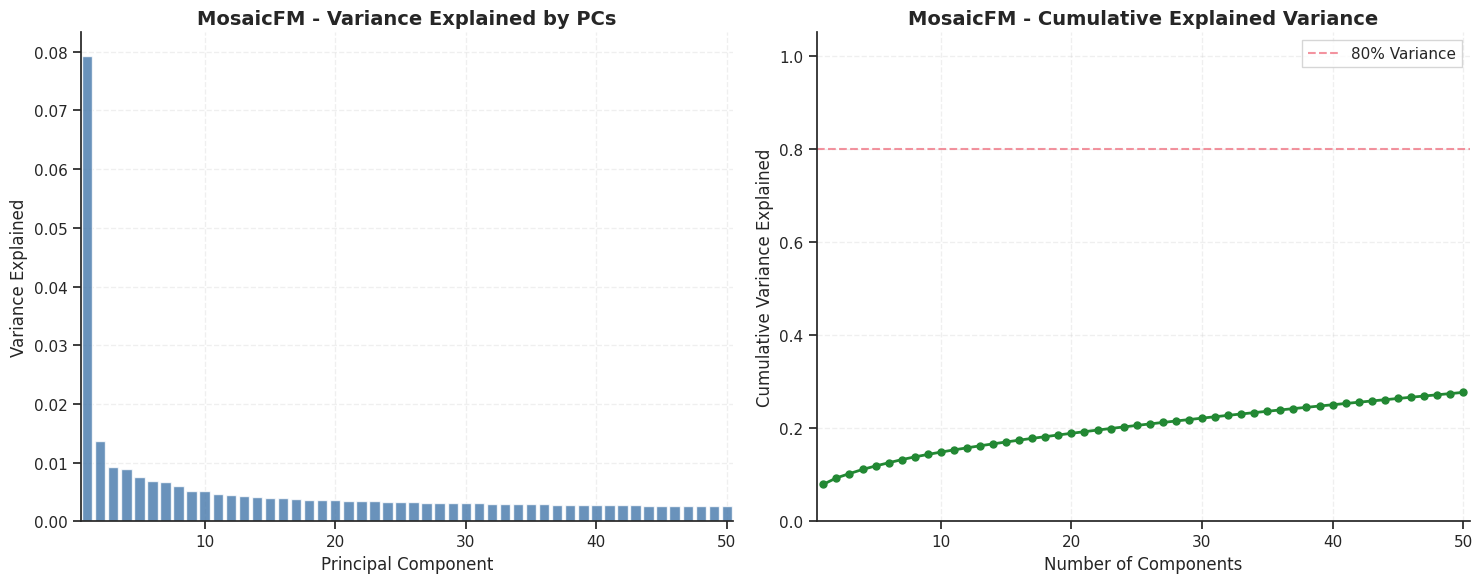

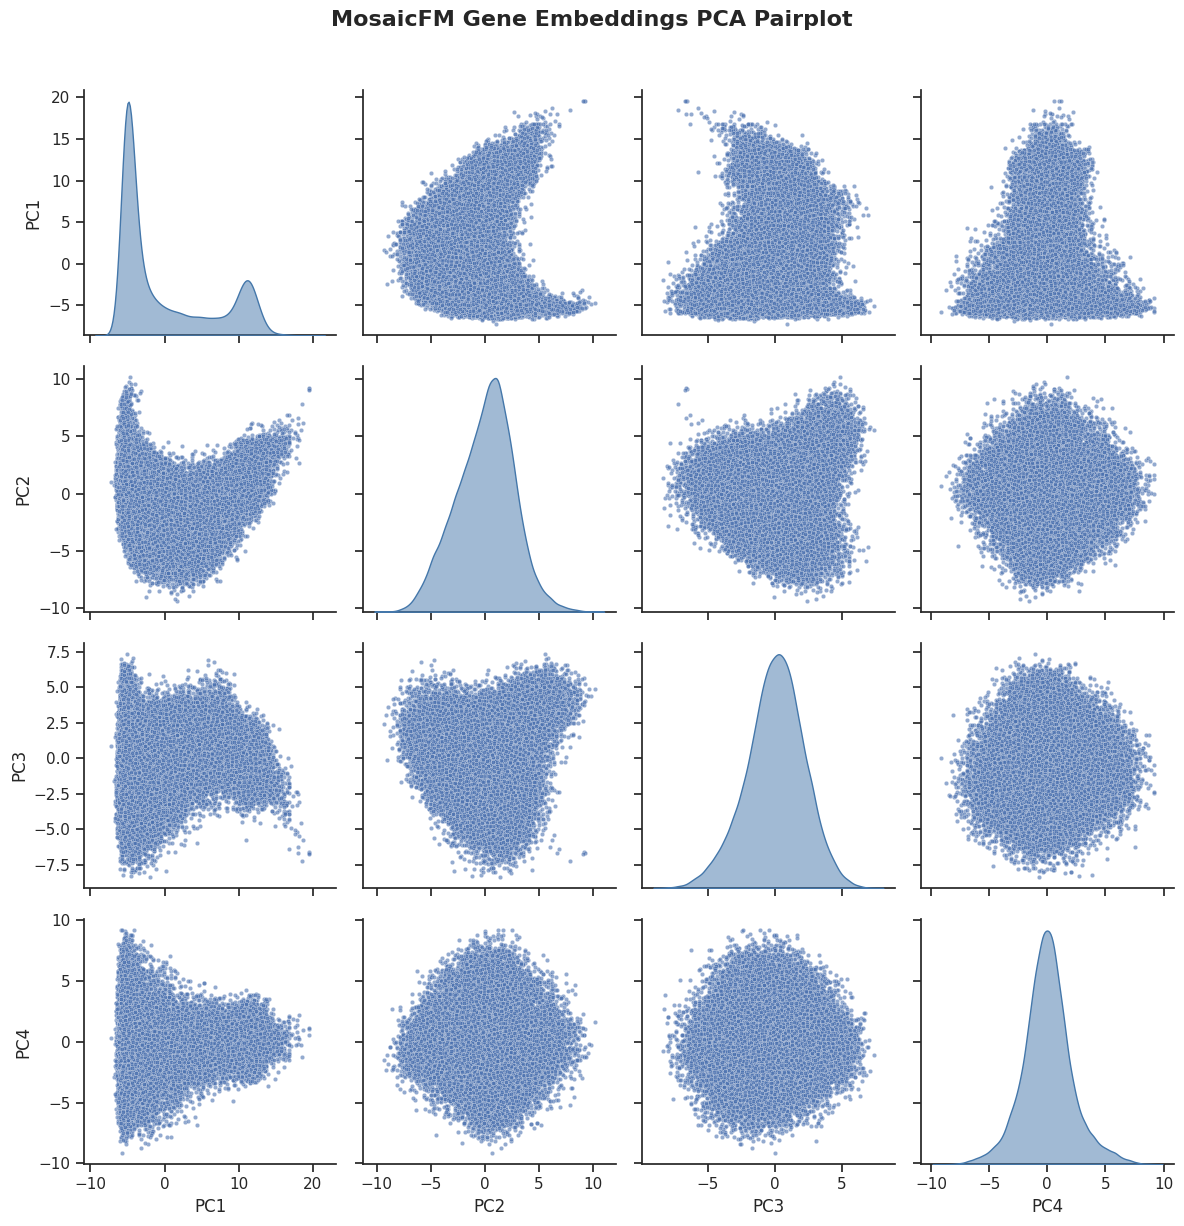

In [17]:
# Perform PCA
n_components = min(50, scaled_embeddings.shape[1])  # Use at most 50 components
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_embeddings)

print(f"PCA result shape: {pca_result.shape}")

# Create figure for variance plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot individual explained variance
ax1.bar(range(1, n_components+1), pca.explained_variance_ratio_, alpha=0.8, color='#4477AA')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Variance Explained', fontsize=12)
ax1.set_title('MosaicFM - Variance Explained by PCs', fontsize=14, fontweight='bold')
ax1.set_xlim(0.5, n_components+0.5)
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate and plot cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
ax2.plot(range(1, n_components+1), cumulative_variance, '-o', 
        markersize=5, linewidth=2, color='#228833')
ax2.axhline(y=0.8, color='#EE6677', linestyle='--', alpha=0.7, 
           label='80% Variance')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Variance Explained', fontsize=12)
ax2.set_title('MosaicFM - Cumulative Explained Variance', fontsize=14, fontweight='bold')
ax2.set_xlim(0.5, n_components+0.5)
ax2.set_ylim(0, 1.05)
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.legend(frameon=True, fancybox=False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add annotation for 80% variance threshold
if np.any(cumulative_variance >= 0.8):
    pc_for_80_percent = np.where(cumulative_variance >= 0.8)[0][0] + 1
    ax2.annotate(f'PC{pc_for_80_percent}', 
                xy=(pc_for_80_percent, 0.8),
                xytext=(pc_for_80_percent+5, 0.75),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=7),
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Create a DataFrame with the gene names and PCA results
pca_df = pd.DataFrame(data=pca_result[:, :4], columns=[f'PC{i+1}' for i in range(4)])

# Visualize top 5 pairs of principal components
g = sns.pairplot(
    pca_df, 
    diag_kind="kde",
    plot_kws={"alpha": 0.6, "s": 10},
    diag_kws={"alpha": 0.5, "color": "#4477AA"},
    height=3
)

g.fig.suptitle('MosaicFM Gene Embeddings PCA Pairplot', 
              fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Running UMAP...
UMAP( verbose=True)
Tue Apr  8 01:08:22 2025 Construct fuzzy simplicial set
Tue Apr  8 01:08:22 2025 Finding Nearest Neighbors
Tue Apr  8 01:08:22 2025 Building RP forest with 18 trees


Tue Apr  8 01:08:27 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	 8  /  16
	 9  /  16
	 10  /  16
	Stopping threshold met -- exiting after 10 iterations
Tue Apr  8 01:08:39 2025 Finished Nearest Neighbor Search
Tue Apr  8 01:08:41 2025 Construct embedding


Epochs completed:  14%| █▍         29/200 [00:01]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs


Epochs completed:  55%| █████▌     110/200 [00:01]

	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs


Epochs completed:  82%| ████████▏  164/200 [00:01]

	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:01]


	completed  180  /  200 epochs
Tue Apr  8 01:08:44 2025 Finished embedding
UMAP completed with shape: (62720, 2)


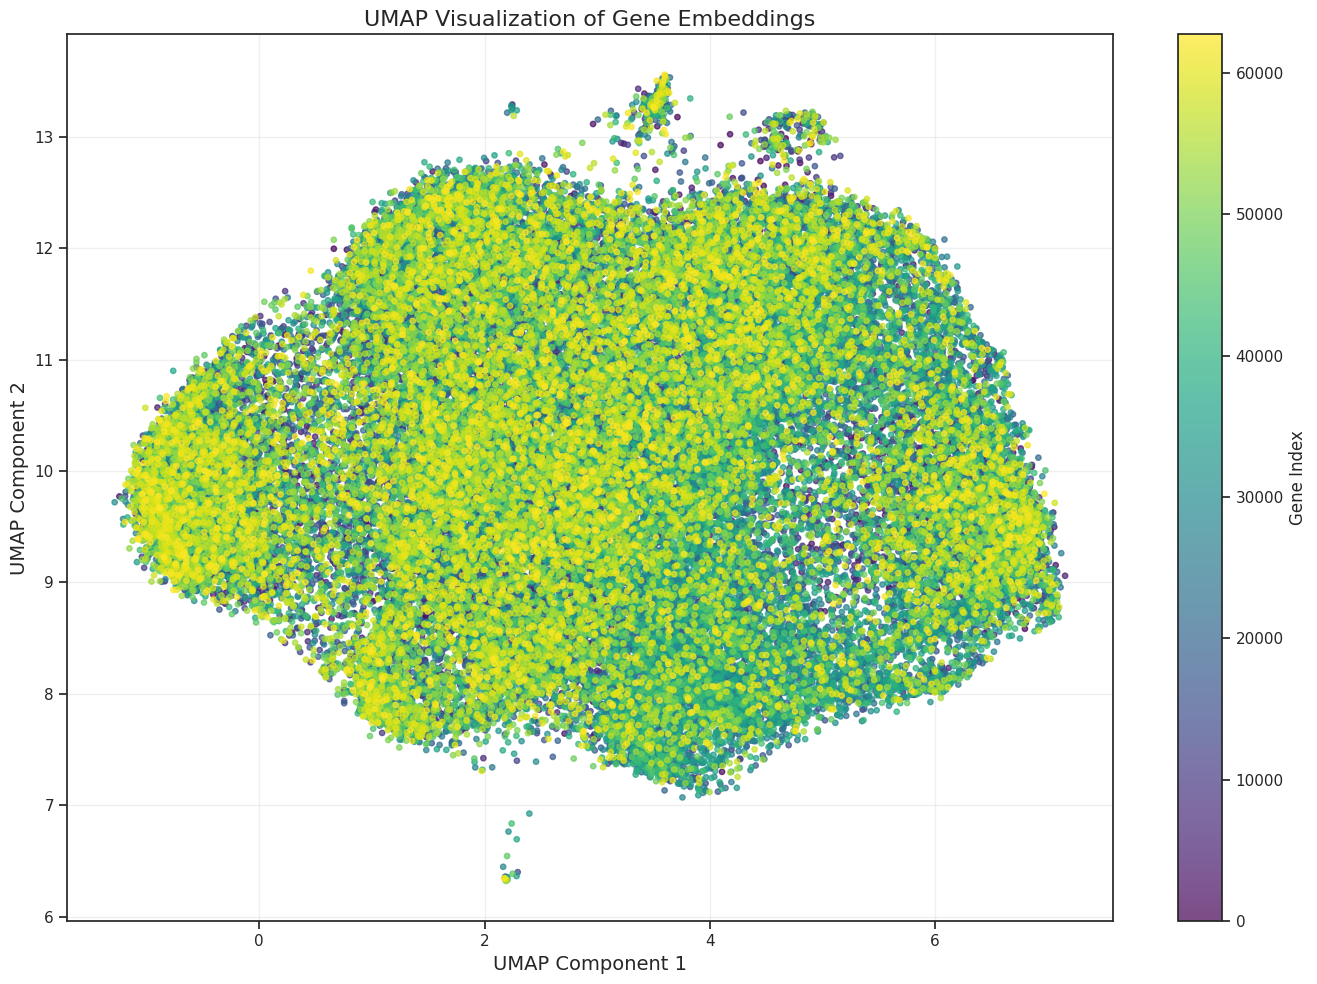

In [10]:
print("Running UMAP...")
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,  # Controls local versus global structure preservation (higher = more global)
    min_dist=0.1,    # Controls how tightly points are packed (lower = tighter clusters)
    metric='euclidean',
    verbose=True
)

umap_results = reducer.fit_transform(scaled_embeddings)
print(f"UMAP completed with shape: {umap_results.shape}")

umap_df = pd.DataFrame({
    'Gene': gene_names,
    'UMAP_1': umap_results[:, 0],
    'UMAP_2': umap_results[:, 1]
})


plt.figure(figsize=(14, 10))

# Create a scatter plot
scatter = plt.scatter(
    umap_df['UMAP_1'], 
    umap_df['UMAP_2'],
    alpha=0.7,
    s=15,
    c=range(len(umap_df)), # Arbitrary, based on order
    cmap='viridis'
)

plt.colorbar(scatter, label='Gene Index')
plt.title('UMAP Visualization of Gene Embeddings', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=14)
plt.ylabel('UMAP Component 2', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
prot = pd.read_csv("/vevo/repo/mosaicfm/scripts/data_prep/esm_embedding/output/human_proteins_processed.tsv", sep="\t")
print("Protein df shape:", prot.shape)
ensembl = pd.read_csv("/vevo/repo/mosaicfm/scripts/data_prep/esm_embedding/data/uniprot_to_ensembl.txt", sep="\t", header=None)
ensembl.columns = ['prot', 'ensembl_id']
print("Ensembl df shape:", ensembl.shape)

Protein df shape: (19329, 11)
Ensembl df shape: (88881, 2)


In [12]:
print("Original ensembl DataFrame:")
print(f"Shape: {ensembl.shape}")
print(ensembl.head())

# Check for duplicates in the 'prot' column
print(f"\nNumber of total rows: {len(ensembl)}")
print(f"Number of unique prot IDs: {ensembl['prot'].nunique()}")
print(f"Number of duplicate prot IDs: {len(ensembl) - ensembl['prot'].nunique()}")

# Remove duplicates, keeping the first occurrence of each protein ID
ensembl_dedup = ensembl.drop_duplicates(subset=['prot'])
print(f"\nAfter removing duplicates: {ensembl_dedup.shape}")

print("\nColumns in prot DataFrame:")
print(prot.columns.tolist())

prot_id_column = prot.columns[0]
print(f"\nAssuming protein ID column is: {prot_id_column}")

# Perform inner join between prot and ensembl_dedup
merged_df = pd.merge(
    prot, 
    ensembl_dedup, 
    left_on=prot_id_column, 
    right_on='prot', 
    how='inner'
)

# Create a new column that removes the dot and version number from ensembl_id, to match MosaicFM vocab 
def remove_version(ensembl_id):
    if pd.isna(ensembl_id):
        return None
    return str(ensembl_id).split('.')[0]

# Apply the function to create the new column
merged_df['ensembl_id_short'] = merged_df['ensembl_id'].apply(remove_version)


print(f"\nAfter inner join:")
print(f"Original prot DataFrame: {prot.shape[0]} rows")
print(f"Deduplicated ensembl DataFrame: {ensembl_dedup.shape[0]} rows")
print(f"Merged DataFrame: {merged_df.shape[0]} rows")
print(f"Percentage of proteins matched: {merged_df.shape[0]/prot.shape[0]*100:.2f}%")

print("\nColumns in merged DataFrame:")
print(merged_df.columns.tolist())

print("\nSample of merged DataFrame with ensembl_id_short:")
print(merged_df[['prot', 'ensembl_id', 'ensembl_id_short']].head(5))

Original ensembl DataFrame:
Shape: (88881, 2)
     prot          ensembl_id
0  P31946  ENSG00000166913.13
1  P62258  ENSG00000108953.17
2  P62258   ENSG00000274474.3
3  Q04917  ENSG00000128245.15
4  P61981   ENSG00000170027.7

Number of total rows: 88881
Number of unique prot IDs: 82312
Number of duplicate prot IDs: 6569

After removing duplicates: (82312, 2)

Columns in prot DataFrame:
['entry', 'gene_names_primary', 'entry_name', 'protein_names', 'gene_names', 'ensembl', 'geneid', 'organism', 'reviewed', 'length', 'sequence']

Assuming protein ID column is: entry

After inner join:
Original prot DataFrame: 19329 rows
Deduplicated ensembl DataFrame: 82312 rows
Merged DataFrame: 19329 rows
Percentage of proteins matched: 100.00%

Columns in merged DataFrame:
['entry', 'gene_names_primary', 'entry_name', 'protein_names', 'gene_names', 'ensembl', 'geneid', 'organism', 'reviewed', 'length', 'sequence', 'prot', 'ensembl_id', 'ensembl_id_short']

Sample of merged DataFrame with ensembl_id_s

Genes found in defined families:
  Hemoglobin: 41 genes
    Examples: HBXIP, HBP1, HBP, HBO1, HBOa ...and 36 more
  Kinases: 389 genes
    Examples: HYKK, MYMK, SGK, HRK, EEF2K ...and 384 more
  Histones: 74 genes
    Examples: HIST1H2BK, HIST1H2AB;, HIST1H2AE, HIST1H2BJ, HIST1H2AG; ...and 69 more
  Collagen: 64 genes
    Examples: COL6A6, COLCA2, COL6A5, COL29A1, COL1A1 ...and 59 more
  Zinc Finger: 776 genes
    Examples: ZNF312B, ZNFD, ZNF785, ZNF593, ZNF195 ...and 771 more


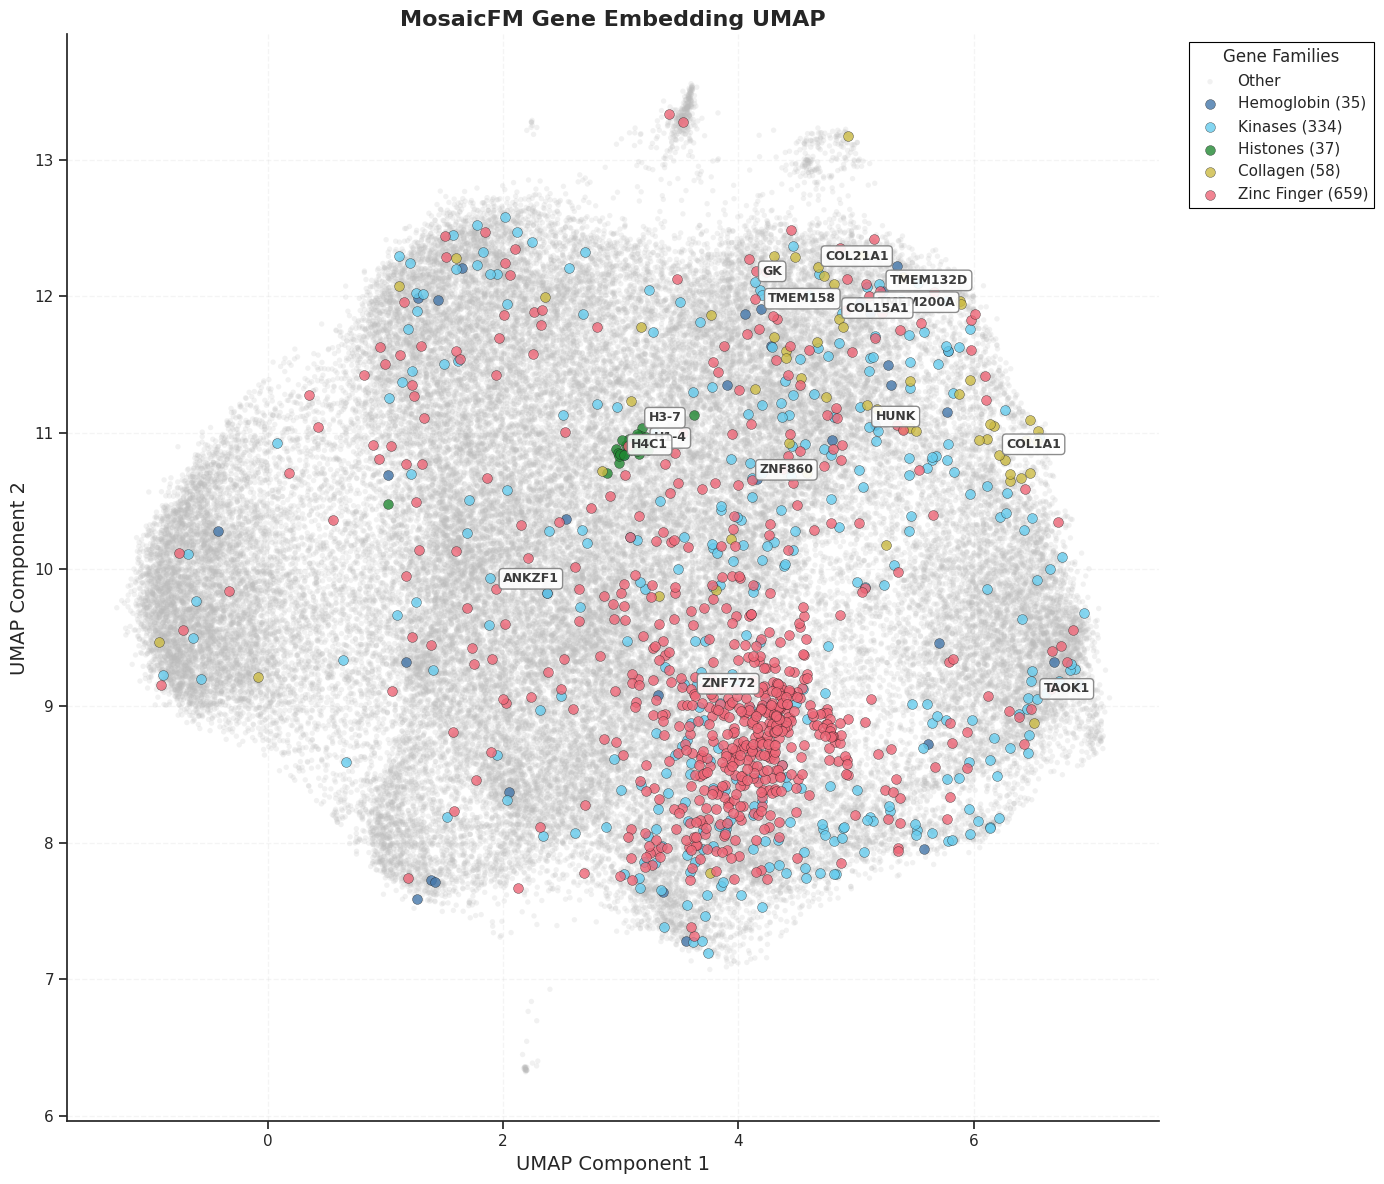

In [13]:
# Create bidirectional mappings between Ensembl IDs and gene names
ensembl_to_gene_name = {}
gene_name_to_ensembl = {}

for _, row in merged_df.iterrows():
    ensembl_id = row['ensembl_id_short']
    gene_names_list = str(row['gene_names']).split()
    
    # Map gene names to Ensembl IDs
    for gene_name in gene_names_list:
        if gene_name and gene_name != 'nan':
            gene_name_to_ensembl[gene_name] = ensembl_id
    
    # Map Ensembl ID to primary gene name
    if gene_names_list and gene_names_list[0] != 'nan':
        ensembl_to_gene_name[ensembl_id] = gene_names_list[0]

# Define gene families based on common naming patterns
gene_families = {
    'Hemoglobin': [g for g in gene_name_to_ensembl if g.startswith('HB')],
    'Kinases': [g for g in gene_name_to_ensembl if g.endswith('K') or 'KIN' in g or 'CDK' in g],
    'Histones': [g for g in gene_name_to_ensembl if g.startswith('HIST')],
    'Collagen': [g for g in gene_name_to_ensembl if g.startswith('COL')],
    'Zinc Finger': [g for g in gene_name_to_ensembl if g.startswith('ZNF')]
}

# Print summary of gene families
print("Genes found in defined families:")
for family, genes in gene_families.items():
    print(f"  {family}: {len(genes)} genes")
    if genes:
        examples = ', '.join(genes[:5])
        print(f"    Examples: {examples}" + (f" ...and {len(genes) - 5} more" if len(genes) > 5 else ""))

# Get Ensembl IDs for each family
family_to_ensembl = {family: [gene_name_to_ensembl[gene] for gene in genes if gene in gene_name_to_ensembl] 
                     for family, genes in gene_families.items()}

# Set up colors for visualization
colors = ['#4477AA', '#66CCEE', '#228833', '#CCBB44', '#EE6677', 
          '#AA3377', '#BBBBBB', '#004488', '#DDAA33']
family_colors = {family: colors[i % len(colors)] for i, family in enumerate(gene_families)}
family_colors['Other'] = '#BBBBBB'  # Gray for 'Other' category

# Create mapping from Ensembl ID to family
ensembl_to_family = {}
for family, ensembl_ids in family_to_ensembl.items():
    for ensembl_id in ensembl_ids:
        ensembl_to_family[ensembl_id] = family

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 12), facecolor='white')
ax.set_facecolor('white')

# Plot background points first
other_indices = [i for i, gene in enumerate(umap_df['Gene']) if gene not in ensembl_to_family]
if other_indices:
    ax.scatter(
        umap_df['UMAP_1'].iloc[other_indices],
        umap_df['UMAP_2'].iloc[other_indices],
        s=15, alpha=0.2, color=family_colors['Other'],
        label='Other', edgecolor='none'
    )

# Plot each gene family
for family, family_ensembl_ids in family_to_ensembl.items():
    family_indices = [i for i, gene in enumerate(umap_df['Gene']) if gene in family_ensembl_ids]
    if family_indices:
        ax.scatter(
            umap_df['UMAP_1'].iloc[family_indices],
            umap_df['UMAP_2'].iloc[family_indices],
            s=50, alpha=0.8, color=family_colors[family],
            label=f'{family} ({len(family_indices)})',
            edgecolor='k', linewidth=0.3
        )

# Add labels for some genes in each family
for family, family_ensembl_ids in family_to_ensembl.items():
    family_indices = [i for i, gene in enumerate(umap_df['Gene']) if gene in family_ensembl_ids]
    if family_indices:
        # Label up to 3 random genes from each family
        label_indices = np.random.choice(family_indices, min(3, len(family_indices)), replace=False)
        for idx in label_indices:
            ensembl_id = umap_df['Gene'].iloc[idx]
            gene_name = ensembl_to_gene_name.get(ensembl_id, ensembl_id)
            ax.annotate(
                gene_name,
                (umap_df['UMAP_1'].iloc[idx], umap_df['UMAP_2'].iloc[idx]),
                fontsize=9, fontweight='bold', alpha=0.9,
                xytext=(5, 5), textcoords='offset points',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9)
            )

# Style the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.2)
ax.set_title('MosaicFM Gene Embedding UMAP', fontsize=16, fontweight='bold')
ax.set_xlabel('UMAP Component 1', fontsize=14)
ax.set_ylabel('UMAP Component 2', fontsize=14)

# Add legend
legend = ax.legend(
    bbox_to_anchor=(1.02, 1), loc='upper left',
    frameon=True, fancybox=False, framealpha=1,
    edgecolor='black', fontsize=11,
    title='Gene Families', title_fontsize=12
)
legend.get_frame().set_linewidth(0.8)

plt.tight_layout()
plt.show()

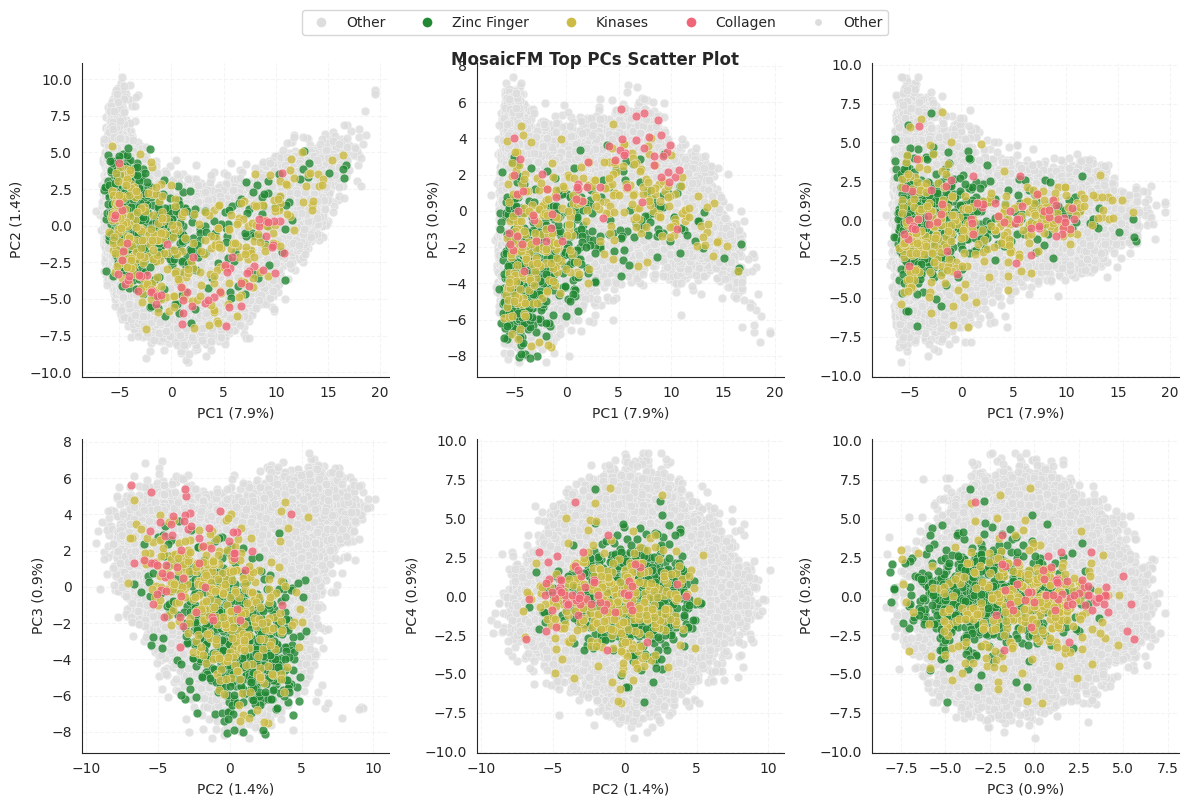

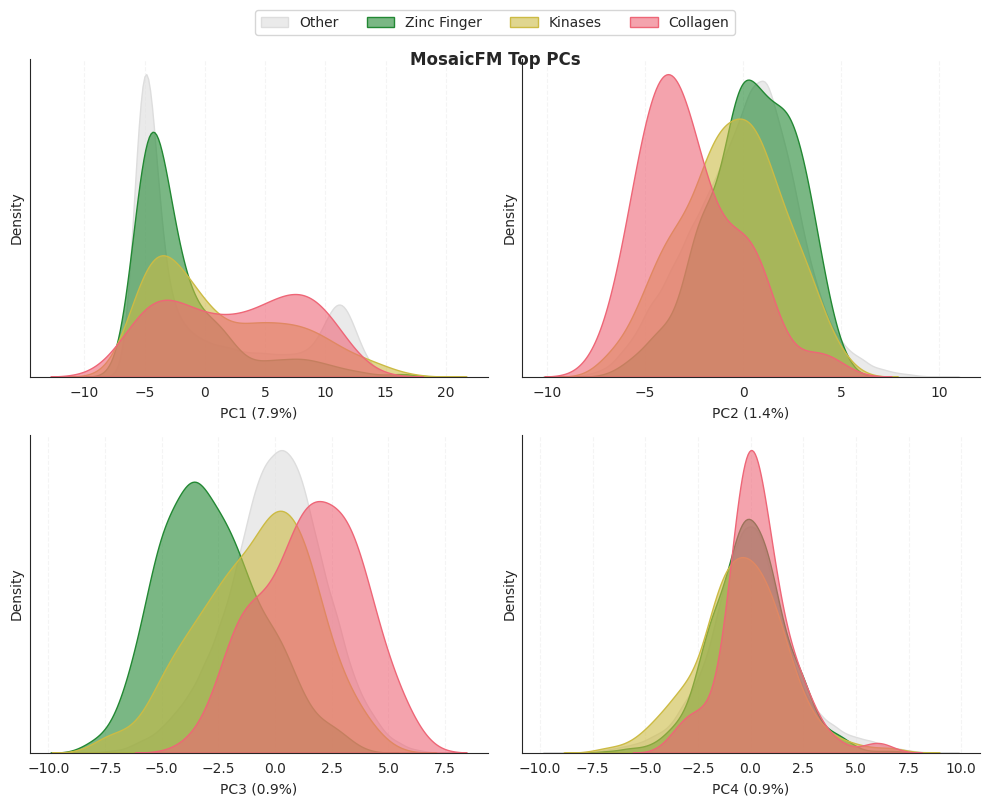

In [14]:
# Set basic styling
plt.style.use('default')
sns.set_style("white")

# Map genes to families
gene_to_family = {}
for family, genes in gene_families.items():
    for gene in genes:
        if gene in gene_name_to_ensembl:
            gene_to_family[gene_name_to_ensembl[gene]] = family

# Add family labels to data
family_labels = [gene_to_family.get(gene, 'Other') for gene in umap_df['Gene']]

# Create PCA dataframe
pc_vars = [f'PC{i+1}' for i in range(4)]
pca_df = pd.DataFrame(pca_result[:, :4], columns=pc_vars)
pca_df['Family'] = family_labels

# Get top families and create highlight column
top_families = pd.Series(family_labels).value_counts().head(4).index.tolist()
pca_df['HighlightFamily'] = pca_df['Family'].apply(
    lambda x: x if x in top_families else 'Other'
)

# Color palette for visualization
colors = {
    top_families[0]: '#4477AA', 
    top_families[1]: '#228833', 
    top_families[2]: '#CCBB44', 
    top_families[3]: '#EE6677', 
    'Other': '#DDDDDD'
}

# Create pairwise scatter plots
fig1, axes1 = plt.subplots(2, 3, figsize=(12, 8), facecolor='white')
axes1 = axes1.flatten()
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

for i, (pc_i, pc_j) in enumerate(pairs):
    ax = axes1[i]
    ax.set_facecolor('white')
    
    # Plot background "Other" points
    other_mask = pca_df['HighlightFamily'] == 'Other'
    ax.scatter(
        pca_df[pc_vars[pc_i]][other_mask], 
        pca_df[pc_vars[pc_j]][other_mask],
        s=10, alpha=0.15, color=colors['Other']
    )
    
    # Plot highlighted family points
    for family in top_families:
        family_mask = pca_df['HighlightFamily'] == family
        ax.scatter(
            pca_df[pc_vars[pc_i]][family_mask], 
            pca_df[pc_vars[pc_j]][family_mask],
            s=40, alpha=0.8, color=colors[family], 
            edgecolor='white', linewidth=0.3
        )
    
    # Style the subplot
    ax.set_xlabel(f"{pc_vars[pc_i]} ({pca.explained_variance_ratio_[pc_i]*100:.1f}%)")
    ax.set_ylabel(f"{pc_vars[pc_j]} ({pca.explained_variance_ratio_[pc_j]*100:.1f}%)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='--', alpha=0.2)

# Add legend to scatter plot figure
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[f], 
               markersize=8, label=f) 
    for f in top_families
]
handles.append(
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['Other'], 
               markersize=6, label='Other')
)
fig1.legend(handles=handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.01))
fig1.suptitle('MosaicFM Top PCs Scatter Plot', y=0.95, fontweight='bold')
fig1.tight_layout()

# Create KDE plots for each PC
fig2, axes2 = plt.subplots(2, 2, figsize=(10, 8), facecolor='white')
axes2 = axes2.flatten()

for i in range(4):
    ax = axes2[i]
    ax.set_facecolor('white')
    
    # Plot density for each family
    for family in top_families:
        family_data = pca_df[pc_vars[i]][pca_df['HighlightFamily'] == family]
        sns.kdeplot(
            x=family_data, ax=ax, color=colors[family], 
            fill=True, alpha=0.6, 
            label=family if i == 0 else None
        )
    
    # Style the subplot
    ax.set_xlabel(f"{pc_vars[i]} ({pca.explained_variance_ratio_[i]*100:.1f}%)")
    ax.set_ylabel('Density')
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='--', alpha=0.2)

# Remove duplicate legend if it exists
if axes2[0].get_legend() is not None:
    axes2[0].get_legend().remove()
    
# Add legend to the KDE figure
fig2.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.01))
fig2.suptitle('MosaicFM Top PCs', y=0.95, fontweight='bold')
fig2.tight_layout()

plt.show()